In [46]:
import numpy as np
import pandas as pd
import torch
from torch import nn

from raphtools.data import load_array
from raphtools import plotter

## Reading the Dataset

In [47]:
TRAIN_DATA_PATH = "/mnt/e/DATASETS/house-prices-advanced-regression-techniques/train.csv"
TEST_DATA_PATH = "/mnt/e/DATASETS/house-prices-advanced-regression-techniques/test.csv"
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

In [48]:
print(train_data.shape, test_data.shape)

print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [49]:
# Remove Id and labels from the features
all_features = pd.concat((train_data.iloc[:, 1: -1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


## Data Preprocessing

In [50]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# After standardizing the data all means vanish, hence we can set missing
# Values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [51]:
# 'Dummy_na=True' considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)

In [52]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

## Training

In [53]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [54]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(torch.mean(loss(torch.log(clipped_preds), torch.log(labels))))
    return rmse.item()

In [55]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            # l = log_rmse(net, X, y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [56]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [57]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batich_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plotter.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 12.025903, valid log rmse 12.004749
fold 2, train log rmse 11.476246, valid log rmse 11.406716
fold 3, train log rmse 8.386711, valid log rmse 8.402927
fold 4, train log rmse 9.193283, valid log rmse 9.214498
fold 5, train log rmse 9.228976, valid log rmse 9.252934
fold 6, train log rmse 8.070322, valid log rmse 8.071840
fold 7, train log rmse 9.253254, valid log rmse 9.203461
fold 8, train log rmse 9.207176, valid log rmse 9.155751
fold 9, train log rmse 8.233919, valid log rmse 8.296465
fold 10, train log rmse 9.329139, valid log rmse 9.287867
10-fold validation: avg train log rmse: 9.440493, avg valid log rmse: 9.429720


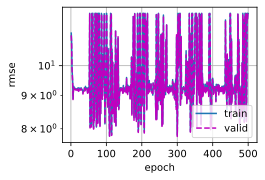

In [58]:
k, num_epochs, lr, weight_decay, batch_size = 10, 500, 10, 0.1, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

## Testing

In [59]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    plotter.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features)
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.detach().reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 9.342031


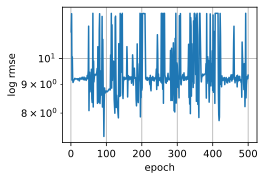

In [60]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)